In [17]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [18]:
# Define a function to load data from multiple files
def load_activity_data(activity, file_prefix, num_files):
    data_list = []
    for i in range(1, num_files + 1):
        file_path = f"Data/{activity}/{file_prefix} {i}cleaned.csv"
        data = np.genfromtxt(file_path, delimiter=',')
        data_list.append(data)
    return np.concatenate(data_list, axis=0)

In [19]:
# Load data for each activity
reading_data = load_activity_data("Reading", "r", 6)
speaking_data = load_activity_data("Speaking", "s", 4)
watching_data = load_activity_data("Watching", "w", 6)

In [20]:
# Create labels for each activity
reading_labels = np.full((reading_data.shape[0],),
    fill_value=0)  # 0 represents reading
speaking_labels = np.full((speaking_data.shape[0],), 
        fill_value=1)  # 1 represents speaking
watching_labels = np.full((watching_data.shape[0],), 
        fill_value=2)  # 2 represents watching



In [21]:
# Concatenate data and labels
X = np.concatenate((reading_data, 
    speaking_data, watching_data), 
    axis=0)
y = np.concatenate((reading_labels, 
            speaking_labels, 
            watching_labels), 
            axis=0)
len(y)

104480

In [22]:
#y_encoded = tf.one_hot(y, 3)
#y_encoded = np.array(y_encoded)
from sklearn.preprocessing import OneHotEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded_reshaped = y_encoded.reshape(-1,1)
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(y_encoded_reshaped)
y_onehot

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [23]:
# Encode labels to numerical values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
        y_onehot, test_size=0.2)

# Reshape data for CNN (assuming data is 1D, 
# modify as needed if your data has more dimensions)

X_train = X_train.reshape(X_train.shape[0],
                 X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], 
            X_test.shape[1], 1)

X_train.shape,X_test.shape

((83584, 5, 1), (20896, 5, 1))

In [24]:
# Build a Convolutional Neural Network (CNN) model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, 
          activation='relu',
            input_shape=(X_train.shape[1], 
                         X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  
    # 3 output neurons for 3 classes 
    #(reading, speaking, watching)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='BinaryCrossentropy',
                metrics=['accuracy'])

batch_size = 32
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size


# Train the model
history = model.fit(X_train, y_train, epochs=20, 
                    batch_size=batch_size, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(X_test, y_test),
                    validation_steps=validation_steps)



Epoch 1/20


2612/2612 [==============================] - 4s 1ms/step - loss: 0.7504 - accuracy: 0.6166 - val_loss: 0.4877 - val_accuracy: 0.6891
Epoch 2/20
2612/2612 [==============================] - 3s 1ms/step - loss: 0.5331 - accuracy: 0.6401 - val_loss: 0.4871 - val_accuracy: 0.6540
Epoch 3/20
2612/2612 [==============================] - 3s 1ms/step - loss: 0.5092 - accuracy: 0.6610 - val_loss: 0.4223 - val_accuracy: 0.7253
Epoch 4/20
2612/2612 [==============================] - 3s 1ms/step - loss: 0.5010 - accuracy: 0.6696 - val_loss: 0.4298 - val_accuracy: 0.7388
Epoch 5/20
2612/2612 [==============================] - 3s 1ms/step - loss: 0.4831 - accuracy: 0.6832 - val_loss: 0.4131 - val_accuracy: 0.7318
Epoch 6/20
2612/2612 [==============================] - 3s 1ms/step - loss: 0.4697 - accuracy: 0.6908 - val_loss: 0.4187 - val_accuracy: 0.7336
Epoch 7/20
2612/2612 [==============================] - 3s 1ms/step - loss: 0.4597 - accuracy: 0.6977 - val_loss: 0.4861 - val_accuracy: 0.7200
Epo

In [25]:
model.save('CNN.keras')

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 3, 64)             256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 4611 (18.01 KB)
Trainable params: 4611 (18.01 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

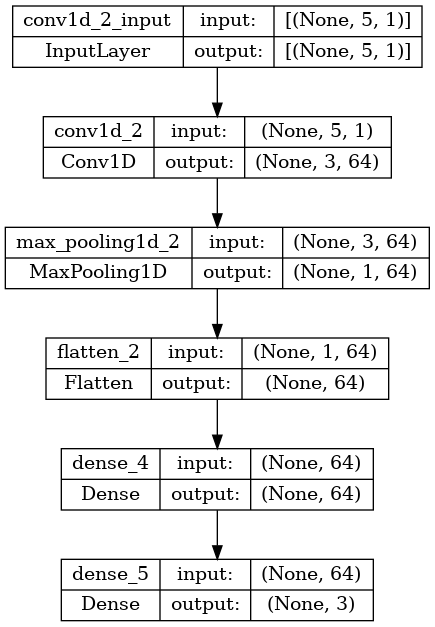

In [27]:
from tensorflow.keras.utils import plot_model


plot_model(model, to_file='model_CNN.png', show_shapes=True)

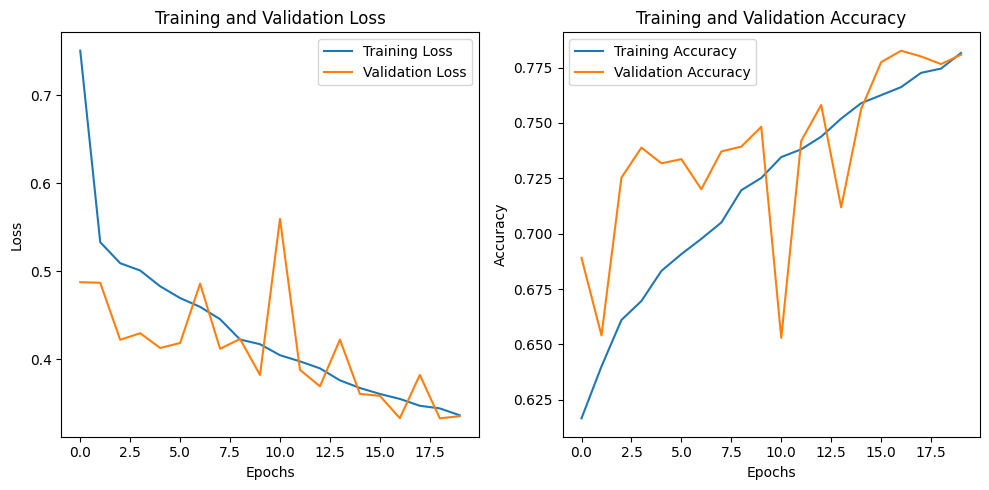

In [33]:
# Plotting loss for training and validation data
plt.figure(figsize=(10, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy for training and validation data
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



653/653 [==============================] - 1s 807us/step


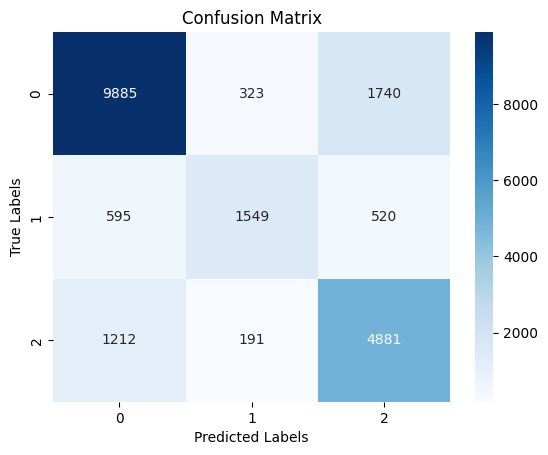

In [32]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Decode labels if necessary
decoded_true_labels = onehot_encoder.inverse_transform(y_test)
decoded_predicted_labels = onehot_encoder.inverse_transform(predictions)

# Create a confusion matrix and plot it with custom labels
conf_matrix = confusion_matrix(decoded_true_labels, 
                               decoded_predicted_labels)
class_labels = label_encoder.classes_

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels,
              yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [35]:
from DeepEEG.input_preparation import get_labels

Labels = get_labels("Data")

def labels(my_dict):
    labels = np.array(list(my_dict.keys()))
    return labels


labels = labels(Labels)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_encoded, labels

(array([1, 0, 2]), array(['Speaking', 'Reading', 'Watching'], dtype='<U8'))

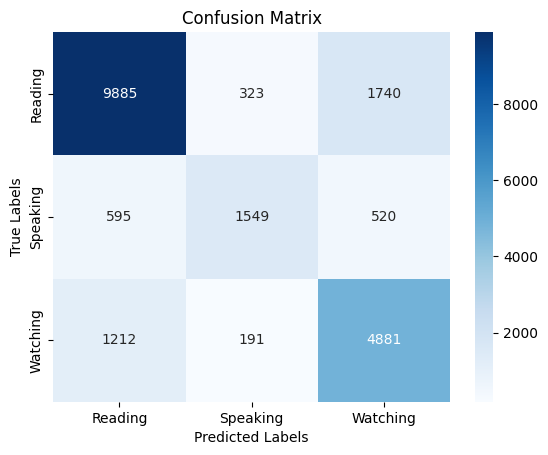

In [37]:
conf_matrix = confusion_matrix(decoded_true_labels, decoded_predicted_labels)
class_labels = label_encoder.classes_

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

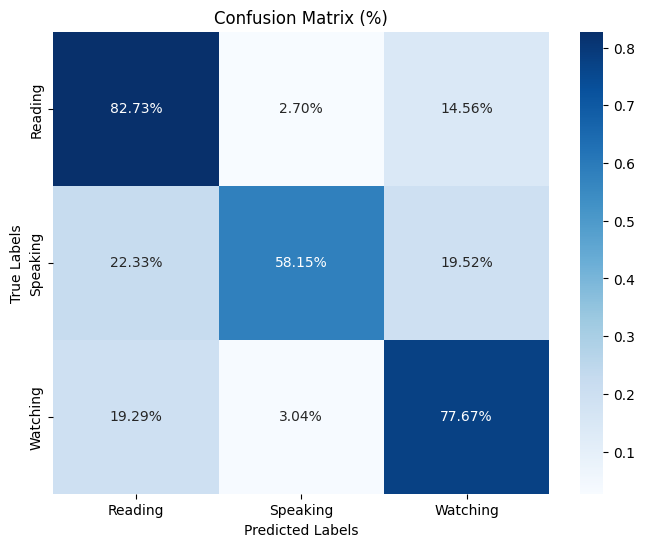

In [38]:
# Calculate confusion matrix with counts
conf_matrix = confusion_matrix(decoded_true_labels, decoded_predicted_labels)

# Calculate percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2%',  xticklabels=class_labels, yticklabels=class_labels  )

# Labeling and visualization settings
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()